In [1]:
import numpy as np
from scipy import optimize, integrate, linalg
import matplotlib.pyplot as plt

In [2]:
def linearized_init(M, m, l, q1, q2, q3, q4, q5, q6, r):
    g = 9.8
    A = np.array(
        [
            [0, 1, 0, 0, 0, 0],
            [0, 0, (4 * m * g) / M, 0, (2 * m * g) / M, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, (g * (M + 4 * m) + M) / (l * M), 0, (g * (M - 2 * m)) / (l * M), 0],
            [0, 0, 0, 0, 0, 1],
            [0, 0, (2 * g) / l, 0, (2 * g) / l, 0],
        ]
    )

    B = np.array([[0], [1 / M], [0], [-1 / (l * M)], [0], [0]])

    # make Q a diagonal matrix with the diagonal [q1, q2, q3, q4]
    Q = np.diag([q1, q2, q3, q4, q5, q6])

    R = np.array([[r]])

    return A, B, Q, R


def find_P(A, B, Q, R):
    """
    Parameters:
    ----------
    A, Q : ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)

    Returns
    -------
    P : the matrix solution of the Riccati equation
    """
    # use scipy.optimize.root to solve the Riccati equation
    def riccati(P):
        P = P.reshape(6, 6)
        are = A.T @ P + P @ A - P @ B @ (np.linalg.inv(R)) @ B.T @ P + Q
        return are.reshape(36)

    P = optimize.root(riccati, np.ones(36)).x
    return P.reshape(6, 6)


def rickshaw(tv, X0, A, B, Q, R, P):
    """
    Parameters:
    ----------
    tv : ndarray of time values, with shape (n+1,)
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    """
    # use scipy.integrate.solve_ivp to solve the ODE
    def ode(t, z):
        are = A - B @ (np.linalg.inv(R)) @ B.T @ P
        return are @ z

    # use t_eval=tv to get the solution at the times in tv
    Z = integrate.solve_ivp(ode, (tv[0], tv[-1]), X0, t_eval=tv).y
    U = -np.linalg.inv(R) @ B.T @ P @ Z
    return Z, U


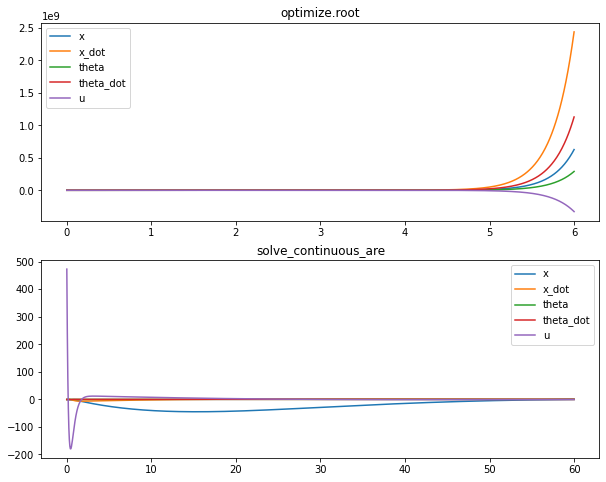

In [3]:
# get the linearized system, and find P
M, m = 23., 5. * 2
l = 4. / 2
q1, q2, q3, q4, q5, q6 = 1., 1., 1., 1., 1., 1.
r = 100.
tf = None
X0 = np.array([-1, -1, .1, -.2, .1, -.2])

A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, q5, q6, r)
P = find_P(A, B, Q, R)
tv = np.linspace(0, 6, 1000)
Z, U = rickshaw(tv, X0, A, B, Q, R, P)

# plot the results
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(tv, Z[0], label="x")
plt.plot(tv, Z[1], label="x_dot")
plt.plot(tv, Z[2], label="theta")
plt.plot(tv, Z[3], label="theta_dot")
plt.plot(tv, U.squeeze(), label="u")
plt.title("optimize.root")
plt.legend()

# get the linearized system, and find P
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, q5, q6, r)
tv = np.linspace(0, 60, 1000)
P = linalg.solve_continuous_are(A, B, Q, R)
Z, U = rickshaw(tv, X0, A, B, Q, R, P)

# plot the results
plt.subplot(2, 1, 2)
plt.plot(tv, Z[0], label="x")
plt.plot(tv, Z[1], label="x_dot")
plt.plot(tv, Z[2], label="theta")
plt.plot(tv, Z[3], label="theta_dot")
plt.plot(tv, U.squeeze(), label="u")
plt.title("solve_continuous_are")
plt.legend()
plt.show()

## Animation time!

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation

In [40]:
M, m = 100., 10. * 2
l = 200.
q1, q2, q3, q4, q5, q6 = 1000., 1., 1., 1., 1., 1.
r = 1.
tf = None
X0 = np.array([0, -9, np.pi, 0, -np.pi, 0])

A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, q5, q6, r)
tv = np.linspace(0, 40, 500)
P = linalg.solve_continuous_are(A, B, Q, R)
Z, U = rickshaw(tv, X0, A, B, Q, R, P)

x = Z[0]
theta_1 = Z[2]
theta_2 = Z[4]

m1 = np.stack((x + l * np.sin(theta_1), l * np.cos(theta_1)), axis=1)
m2 = np.stack((x + l * np.sin(theta_1) + l * np.sin(theta_2), l * np.cos(theta_1) + l * np.cos(theta_2)), axis=1)

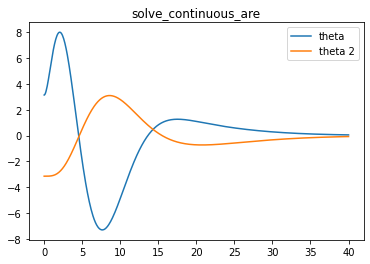

In [41]:
# plt.plot(tv, Z[0], label="x")
# plt.plot(tv, Z[1], label="x_dot")
plt.plot(tv, Z[2], label="theta")
# plt.plot(tv, Z[3], label="theta_dot")
# plt.plot(tv, U.squeeze(), label="u")
plt.plot(tv, Z[4], label="theta 2")
plt.title("solve_continuous_are")
plt.legend()
plt.show()

In [42]:
min(x), max(x), min(min(m1[:, 0]), min(m2[:, 0])), max(max(m1[:, 0]), max(m2[:, 0])), min(min(m1[:, 1]), min(m2[:, 1])), max(max(m1[:, 1]), max(m2[:, 1])), (max(x) - min(x)) / (2 * l)

(-815.395098856346,
 4613.945678530061,
 -667.4446487409749,
 4481.445172847093,
 -400.0,
 399.18635583442176,
 13.573351943466015)

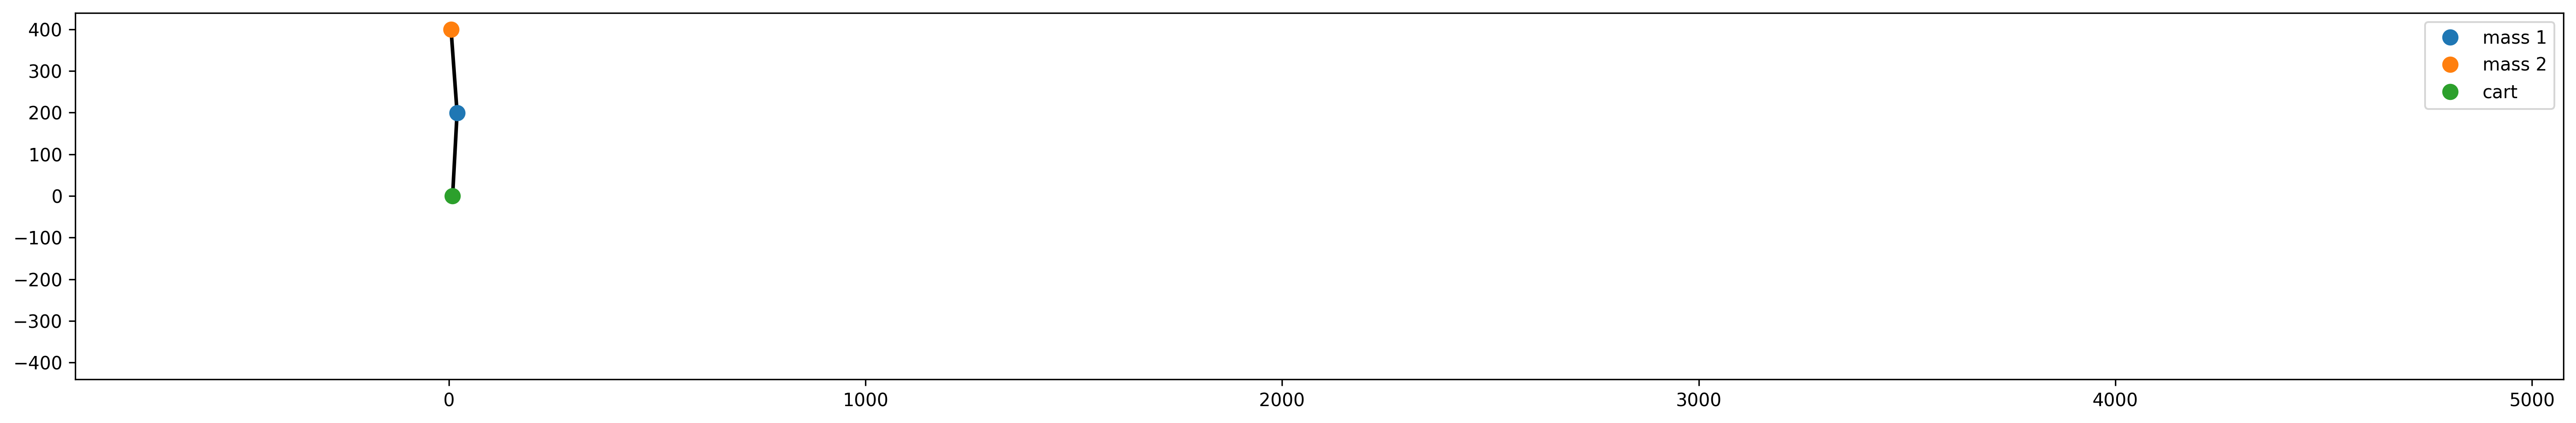

In [43]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(20, 5), dpi=300)

# Set up the plots we will draw
(m1_plot,) = plt.plot([], [], "o", ms=8, label="mass 1", zorder=10)
(m2_plot,) = plt.plot([], [], "o", ms=8, label="mass 2", zorder=10)
(line1,) = plt.plot([], [], "k-", lw=2)
(line2,) = plt.plot([], [], "k-", lw=2)
(cart_plot,) = plt.plot([], [], "o", ms=8, label="cart", zorder=10)

# Initialization function
def init():
    plt.tight_layout()
    ax.set_xlim(1.1 * min(x), 1.1 * max(x))
    ax.set_ylim(1.1 * min(min(m1[:, 1]), min(m2[:, 1])), 1.1 * max(max(m1[:, 1]), max(m2[:, 1])))
    ax.legend()
    ax.set_aspect("equal")
    return (
        m1_plot,
        m2_plot,
        line1,
        line2,
        cart_plot,
    )


# Update function for the animation
def update(frame):
    m1_plot.set_data(m1[frame, 0], m1[frame, 1])
    m2_plot.set_data(m2[frame, 0], m2[frame, 1])
    line1.set_data([x[frame], m1[frame, 0]], [0, m1[frame, 1]])
    line2.set_data([m1[frame, 0], m2[frame, 0]], [m1[frame, 1], m2[frame, 1]])
    cart_plot.set_data(x[frame], 0)
    return (
        m1_plot,
        m2_plot,
        line1,
        line2,
        cart_plot,
    )


# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(tv), init_func=init, interval=50)
ani.save("pendulum.mp4", writer="ffmpeg")

# Display the animation
plt.show()
